In [37]:
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFilter
from sklearn.preprocessing import LabelEncoder
import timeit
import cv2 as cv
import argparse

#Neural Network packages

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
from torchvision import models
from torch.autograd import Variable

In [38]:
os.getcwd()

'/home/ajith/Machine_Learning/Projects/Intel image Classification'

150 150


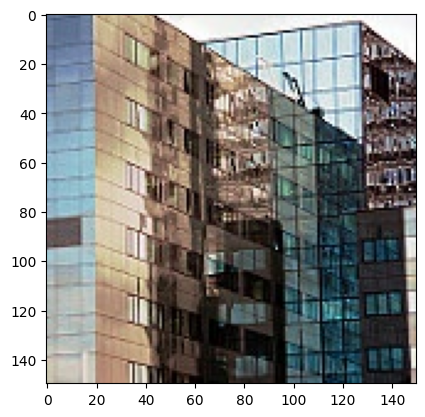

In [39]:
im=Image.open('seg_train/seg_train/buildings/137.jpg')
width, height= im.size
print(width,height)
plt.imshow(im)

In [40]:
transform = transforms.Compose([transforms.Resize(256),
                                transforms.RandomHorizontalFlip(),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0,0,0], 
                                                    [1,1,1])])

In [41]:
# Custom Dataset Class
class INTELDataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
   
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = Image.open(img_name)
        image = image.convert('RGB')
        #image = image.resize((300,300))
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    
    
    def __len__(self):
        return len(self.img_data)

In [44]:
base_path_train='seg_train'

In [45]:
images_train=[]
labels_train=[]


for file in os.listdir(os.path.join(base_path_train,'seg_train')):
  if file=='buildings':
    for img in os.listdir(os.path.join(base_path_train,'seg_train', file)):
      images_train.append(img)
      labels_train.append('buildings')
  if file=='forest':
    for img in os.listdir(os.path.join(base_path_train,'seg_train', file)):
      images_train.append(img)
      labels_train.append('forest')      
  if file=='glacier':
    for img in os.listdir(os.path.join(base_path_train,'seg_train', file)):
      images_train.append(img)
      labels_train.append('glacier')
  if file=='mountain':
    for img in os.listdir(os.path.join(base_path_train,'seg_train', file)):
      images_train.append(img)
      labels_train.append('mountain')  
  if file=='sea':
    for img in os.listdir(os.path.join(base_path_train,'seg_train', file)):
      images_train.append(img)
      labels_train.append('sea')  
  if file=='street':
    for img in os.listdir(os.path.join(base_path_train,'seg_train', file)):
      images_train.append(img)
      labels_train.append('street')      

data_train= {'Images': images_train, 'labels':labels_train}     
data_train=pd.DataFrame(data_train)
print(data_train.head(10))

      Images     labels
0   9767.jpg  buildings
1   2743.jpg  buildings
2  18548.jpg  buildings
3   9517.jpg  buildings
4   5741.jpg  buildings
5  18397.jpg  buildings
6   7758.jpg  buildings
7  19556.jpg  buildings
8  14454.jpg  buildings
9   7544.jpg  buildings


In [46]:
data_train.labels.value_counts()

mountain     2512
glacier      2404
street       2382
sea          2274
forest       2271
buildings    2191
Name: labels, dtype: int64

In [47]:
# Encoding the string labels to digits
encoder= LabelEncoder()
data_train['encoded_labels']= encoder.fit_transform(data_train['labels'])
data_train.head(10)
data_train.encoded_labels.value_counts()

3    2512
2    2404
5    2382
4    2274
1    2271
0    2191
Name: encoded_labels, dtype: int64

In [48]:
train_batch_size=32
random_seed=50


In [49]:
# Create train sampler
train_indices = list(range(len(data_train)))

train_sampler = SubsetRandomSampler(train_indices)

In [50]:
#training image path
path_train=os.path.join(base_path_train,'seg_train')
print(path_train)

seg_train/seg_train


In [51]:
dataset_train = INTELDataset(data_train,path_train,transform)



train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=train_batch_size, 
                                           sampler=train_sampler)

In [57]:
#Check the size of a test images
im=Image.open('seg_test/seg_test/street/20719.jpg')
width, height= im.size
print(width,height)

150 150


In [60]:
base_path_test='seg_test'

In [61]:
images_test=[]
labels_test=[]


for file in os.listdir(os.path.join(base_path_test,'seg_test')):
  if file=='buildings':
    for img in os.listdir(os.path.join(base_path_test,'seg_test', file)):
      images_test.append(img)
      labels_test.append('buildings')
  if file=='forest':
    for img in os.listdir(os.path.join(base_path_test,'seg_test', file)):
      images_test.append(img)
      labels_test.append('forest')      
  if file=='glacier':
    for img in os.listdir(os.path.join(base_path_test,'seg_test', file)):
      images_test.append(img)
      labels_test.append('glacier')
  if file=='mountain':
    for img in os.listdir(os.path.join(base_path_test,'seg_test', file)):
      images_test.append(img)
      labels_test.append('mountain')  
  if file=='sea':
    for img in os.listdir(os.path.join(base_path_test,'seg_test', file)):
      images_test.append(img)
      labels_test.append('sea')  
  if file=='street':
    for img in os.listdir(os.path.join(base_path_test,'seg_test', file)):
      images_test.append(img)
      labels_test.append('street')      

data_test= {'Images': images_test, 'labels':labels_test}     
data_test=pd.DataFrame(data_test)
print(data_test.head(10))

      Images     labels
0  20597.jpg  buildings
1  22415.jpg  buildings
2  20828.jpg  buildings
3  23660.jpg  buildings
4  21279.jpg  buildings
5  22045.jpg  buildings
6  23100.jpg  buildings
7  23315.jpg  buildings
8  24103.jpg  buildings
9  20515.jpg  buildings


In [62]:
# Encoding the string labels to digits
encoder= LabelEncoder()
data_test['encoded_labels']= encoder.fit_transform(data_test['labels'])
data_test.head(10)
data_test.encoded_labels.value_counts()

2    553
3    525
4    510
5    501
1    474
0    437
Name: encoded_labels, dtype: int64

In [63]:
path_test=os.path.join(base_path_test,'seg_test')

In [64]:
# Creating Test Sampler
test_indices = list(range(len(data_test)))

test_sampler = SubsetRandomSampler(test_indices)

In [65]:
test_batch_size=20

In [66]:
dataset_test = INTELDataset(data_test,path_test,transform)



test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=test_batch_size, 
                                           sampler=test_sampler)


In [67]:
def train(model,train_loader, criterion, optimizer, epoch):
    model.cpu()
    model.train()
    train_losses=[]
    for batch_idx, (data, target) in enumerate(train_loader):
       
       
        # flush out the gradients stored in optimizer
        optimizer.zero_grad()
        # pass the image to the model and assign the output to variable named output
        output = model(data)
        # calculate the loss (use cross entropy in pytorch)
        loss = criterion(output, target)
        #appending train loss list
        train_losses.append(loss.item())
        # do a backward pass
        loss.backward()
        # update the weights
        optimizer.step()
     
        if batch_idx % 32 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    return train_losses

In [68]:
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
          
    
            # pass the image to the model and assign the output to variable named output
            output = model(data)
            #print(output)
         
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    #print(output)
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [69]:
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
num_features= model.fc.in_features
model.fc = nn.Linear(num_features, 6)


criterion = nn.CrossEntropyLoss()
#Define Adam Optimiser with a learning rate of 0.01
optimizer = optim.Adam(model.fc.parameters(), lr=0.01)

start = timeit.default_timer()
for epoch in range(1, 11):
    train(model, train_loader, criterion, optimizer, epoch)
    test(model, test_loader, criterion)
stop = timeit.default_timer()
print('Total time taken: {} seconds'.format(int(stop - start)) )

/home/ajith/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ajith/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train Epoch: 1 [0/14034 (0%)]	Loss: 1.932995
Train Epoch: 1 [1024/14034 (7%)]	Loss: 0.426005
Train Epoch: 1 [2048/14034 (15%)]	Loss: 0.218966
Train Epoch: 1 [3072/14034 (22%)]	Loss: 0.471033
Train Epoch: 1 [4096/14034 (29%)]	Loss: 0.665325
Train Epoch: 1 [5120/14034 (36%)]	Loss: 0.294132
Train Epoch: 1 [6144/14034 (44%)]	Loss: 1.681753
Train Epoch: 1 [7168/14034 (51%)]	Loss: 0.143626
Train Epoch: 1 [8192/14034 (58%)]	Loss: 0.596124
Train Epoch: 1 [9216/14034 (66%)]	Loss: 1.562491
Train Epoch: 1 [10240/14034 (73%)]	Loss: 0.484730
Train Epoch: 1 [11264/14034 (80%)]	Loss: 0.355537
Train Epoch: 1 [12288/14034 (87%)]	Loss: 1.122657
Train Epoch: 1 [13312/14034 (95%)]	Loss: 0.667426

Test set: Average loss: 0.0250, Accuracy: 2636/3000 (88%)

Train Epoch: 2 [0/14034 (0%)]	Loss: 0.222343
Train Epoch: 2 [1024/14034 (7%)]	Loss: 0.518530
Train Epoch: 2 [2048/14034 (15%)]	Loss: 1.142039
Train Epoch: 2 [3072/14034 (22%)]	Loss: 0.780080
Train Epoch: 2 [4096/14034 (29%)]	Loss: 0.725089
Train Epoch: 2 

In [73]:
valid_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                     ])

In [97]:
def predict_image(image):
    image_tensor = valid_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    output = model(image_tensor)
    index = output.data.cpu().numpy().argmax()
    vector={0:'buildings',1:'forest',2:'glacier',3:'mountain',4:'sea',5:'street'}
    obj=vector[index]
    
        
    return obj

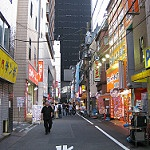

In [98]:
im=Image.open('seg_pred/seg_pred/284.jpg')
im

In [106]:
predict_image(im)

'street'